In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
sys.path.append('../../')

titanic_df = pd.read_csv('titanic_data/data.csv')
titanic_df['Survived'] = titanic_df['Survived'].map({0: 'Died', 1: 'Survived'})

In [2]:
import tabularmagic as tm
analyzer = tm.Analyzer(titanic_df, test_size=0.2, name='titanic')
analyzer

INFO: Analyzer initialized. Shapes of train, test DataFrames: (712, 12), (179, 12). 


titanic 
----------------------------------------------------------------------------------------
Train shape: (712, 12)                      Test shape: (179, 12)                       
----------------------------------------------------------------------------------------
Categorical variables:
  'Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked' 
                                                                                        
Numeric variables:
  'PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare' 

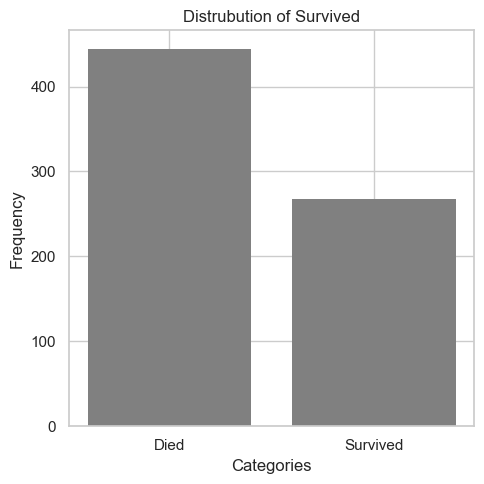

In [3]:
analyzer.eda().plot_distribution('Survived')

In [4]:
analyzer.load_data_checkpoint()
analyzer.impute(numeric_strategy='5nn').scale()

report = analyzer.classify(
    models=[
        tm.ml.LinearC('no_penalty'),
        tm.ml.LinearC('l1'),
        tm.ml.LinearC('l2'),
        tm.ml.TreeEnsembleC('random_forest', n_trials=10)
    ],
    target='Survived',
    predictors=[
        'Pclass',
        'Sex',
        'Fare',
        'Age'
    ]
)

INFO: Working DataFrames reset to original DataFrames. Shapes of train, test DataFrames: 
      (712, 12), (179, 12). 
INFO: Imputed missing values with numeric strategy 5nn and categorical strategy 
      most_frequent. 
INFO: Scaled variables 'PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare' using 
      strategy standardize. 
INFO: Evaluating model LinearC(no_penalty). 
PROG: Fitting LinearC(no_penalty). Search method: GridSearchCV (1 fits per fold, 5 total 
      fits). 
PROG: Optimal threshold set for LinearC(no_penalty) via F1 score. 
INFO: Successfully evaluated model LinearC(no_penalty). 
INFO: Evaluating model LinearC(l1). 
PROG: Fitting LinearC(l1). Search method: OptunaSearchCV (100 trials). 
PROG: Optimal threshold set for LinearC(l1) via F1 score. 
INFO: Successfully evaluated model LinearC(l1). 
INFO: Evaluating model LinearC(l2). 
PROG: Fitting LinearC(l2). Search method: OptunaSearchCV (100 trials). 
PROG: Optimal threshold set for LinearC(l2) via F1 score. 
INFO

In [5]:
report.metrics()

,LinearC(no_penalty),LinearC(l1),LinearC(l2),TreeEnsembleC(random_forest)
Statistic,,,,
accuracy,0.810056,0.810056,0.804469,0.804469
f1,0.795181,0.795181,0.782609,0.774194
precision,0.717391,0.717391,0.724138,0.740741
recall,0.891892,0.891892,0.851351,0.810811
roc_auc,0.87426,0.873745,0.874003,0.869369
n_obs,179,179,179,179


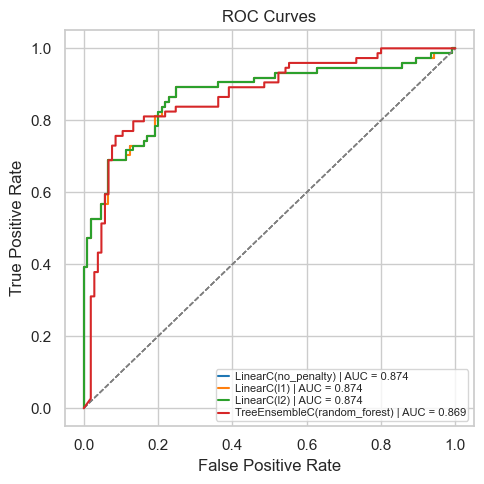

In [6]:
report.plot_roc_curves('test')

In [7]:
report.plot_confusion_matrix('LinearC(l1)')
print(report.model('LinearC(l1)').pos_label())

Survived


In [8]:
report.feature_importance('LinearC(no_penalty)')

,Coefficients
Feature,
male_yn(Sex),-2.575895
Pclass,-0.862971
Fare,0.050718
Age,-0.379166


In [9]:
report.feature_importance('TreeEnsembleC(random_forest)')

,Importances
Feature,
male_yn(Sex),0.343803
Pclass,0.124502
Fare,0.268053
Age,0.263642


In [10]:
glm_report = analyzer.glm(
    'binomial',
    target='Survived',
    predictors=[
        'Pclass',
        'Sex',
        'Fare',
        'Age'
    ]
)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [23]:
glm_report.statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  572
Model:                            GLM   Df Residuals:                      567
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -267.21
Date:                Sun, 04 Aug 2024   Deviance:                       534.42
Time:                        06:10:40   Pearson chi2:                     595.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3404
Covariance Type:                  HC3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.3005      0.602      7.147      0.000       3.121       5.480
male_yn(Sex)    -2.4775      0.220    -11.276      0.000      -2.908      -2.047
Pclass          -1.0853      0.174     -6.234      0.000      -1.427      -0.744
Fare             0.0010      0.002      0.502      0.616      -0.003       0.005
Age             -0.0276      0.009     -3.182      0.001      -0.045      -0.011
================================================================================
"""